In [1]:
model_dir = 'VineyardDetection.h5'
img_height, img_width = 299, 299
valid_dir = 'data/vineyard/valid/'

In [2]:
import os
import glob
import random
import operator
import functools
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import to_categorical

model = load_model(model_dir)

label = os.listdir(valid_dir)  #list, name of each class. such as ['low', 'tv', 'waste']
label_dict = dict(zip(list(range(len(label))), label))  #dict, constructed by classes. such as {0: 'low', 1: 'tv', 2: 'waste'}
n_label = []  #list, number of each class. such as [1,1,1]

n_classes = len(label)

pictures_dir = []  #list, path of all pictures. such as ['a/1.jpg','b/1.jpg','c/1.jpg']
for l in label:
    path = os.path.join(valid_dir, l)
    files = glob.glob(path + '\\' + '*.*')
    pictures_dir.append(files)
    n_label.append(len(files))
pictures_dir = functools.reduce(operator.concat, pictures_dir)  # 2D to 1D

Using TensorFlow backend.


In [3]:
for _ in range(n_classes):
    index = random.randint(0, len(pictures_dir) - 1)
    path = pictures_dir[index]
    print('File:', path)
    x = image.load_img(path=path, target_size=(img_height, img_width))
    x = image.img_to_array(x)
    x = x[None]
    y = model.predict(x)

    for i in np.argsort(y[0])[::-1]:
        print('{}: {:.2f}%'.format(label_dict[i], y[0][i] * 100))

    print()

File: data/vineyard/valid/jianzhu\jianzhu (519).jpg
jianzhu: 100.00%
qita: 0.00%
gengdi: 0.00%
sheshi: 0.00%
luodi: 0.00%

File: data/vineyard/valid/sheshi\sheshi (119).jpg
sheshi: 100.00%
luodi: 0.00%
jianzhu: 0.00%
qita: 0.00%
gengdi: 0.00%

File: data/vineyard/valid/qita\qita (616).jpg
qita: 100.00%
gengdi: 0.00%
sheshi: 0.00%
luodi: 0.00%
jianzhu: 0.00%

File: data/vineyard/valid/luodi\luodi (218).jpg
luodi: 100.00%
gengdi: 0.00%
sheshi: 0.00%
jianzhu: 0.00%
qita: 0.00%

File: data/vineyard/valid/luodi\luodi (002).jpg
luodi: 97.05%
gengdi: 1.82%
sheshi: 0.44%
jianzhu: 0.39%
qita: 0.30%



In [4]:
y_scores = []  #np.array, predicted results. such as [[],[],[]]
y_pred = []  #np.array, predicted label. such as[1, 0, 2]

for path in pictures_dir:
    x = image.load_img(path=path, target_size=(img_height, img_width))
    x = image.img_to_array(x)
    x = x[None]
    y = model.predict(x)
    y_scores.append(y)
    y_pred.append(np.argmax(y))

y_scores = np.array(y_scores).reshape(len(y_scores), -1)
y_pred = np.array(y_pred)

In [5]:
y_true = np.array([])  #np.array, true label. such as[1, 0, 2]
for i in range(len(n_label)):
    y_true = np.concatenate([y_true, np.full(n_label[i], i)])

In [6]:
import numpy as np
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Error rate: {:.2f}%'.format((1 - accuracy) * 100))

Accuracy: 98.60%
Error rate: 1.40%


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='weighted')
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1: {:.2f}%'.format(f1 * 100))

Precision: 98.61%
Recall: 98.60%
F1: 98.60%


In [8]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true, y_pred)

array([[199,   0,   0,   0,   1],
       [  0, 198,   0,   2,   0],
       [  0,   0, 199,   1,   0],
       [  1,   2,   0, 196,   1],
       [  0,   1,   0,   5, 194]], dtype=int64)

In [9]:
import seaborn as sn
import matplotlib.pyplot as plt

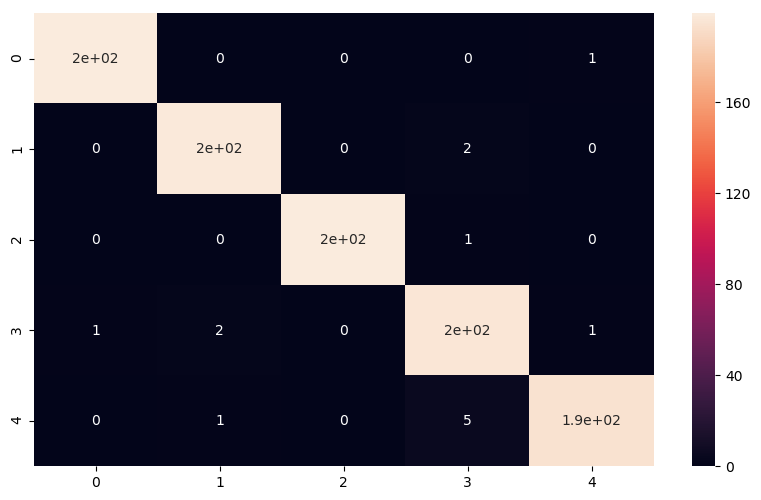

In [10]:
plt.figure(figsize=(10, 6), dpi=100)
sn.heatmap(confusion_matrix(y_true, y_pred), annot=True)

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=label))

              precision    recall  f1-score   support

      gengdi       0.99      0.99      0.99       200
     jianzhu       0.99      0.99      0.99       200
       luodi       1.00      0.99      1.00       200
        qita       0.96      0.98      0.97       200
      sheshi       0.99      0.97      0.98       200

   micro avg       0.99      0.99      0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [12]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true)[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print('AUC class {}: {:.4f}'.format(i, roc_auc[i]))

# AUC of micro-average
fpr['micro'], tpr['micro'], _ = roc_curve(to_categorical(y_true).ravel(), y_scores.ravel())
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])
print('AUC micro-average: {:.4f}'.format(roc_auc['micro']))

# AUC of macro-average
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])
print('AUC macro-average: {:.4f}'.format(roc_auc['macro']))

AUC class 0: 1.0000
AUC class 1: 1.0000
AUC class 2: 1.0000
AUC class 3: 0.9994
AUC class 4: 0.9996
AUC micro-average: 0.9998
AUC macro-average: 0.9998


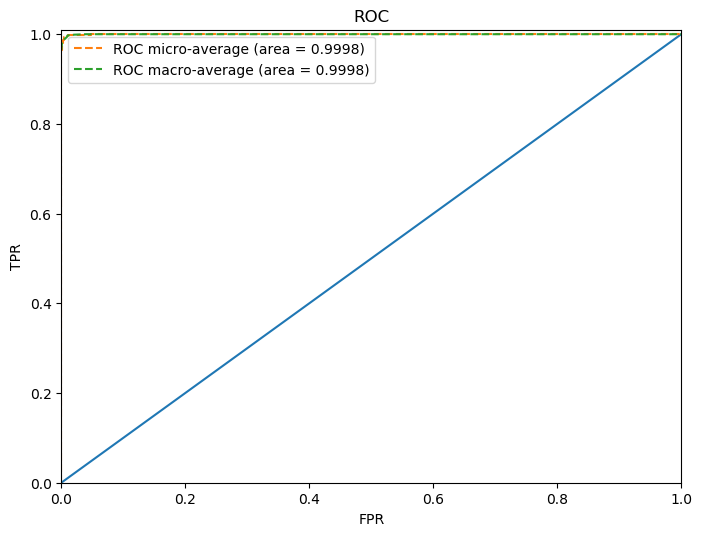

In [13]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot([0, 1])
plt.plot(fpr['micro'], tpr['micro'], label='ROC micro-average (area = {:.4})'.format(roc_auc['micro']), linestyle='--')
plt.plot(fpr['macro'], tpr['macro'], label='ROC macro-average (area = {:.4})'.format(roc_auc['macro']), linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.show()

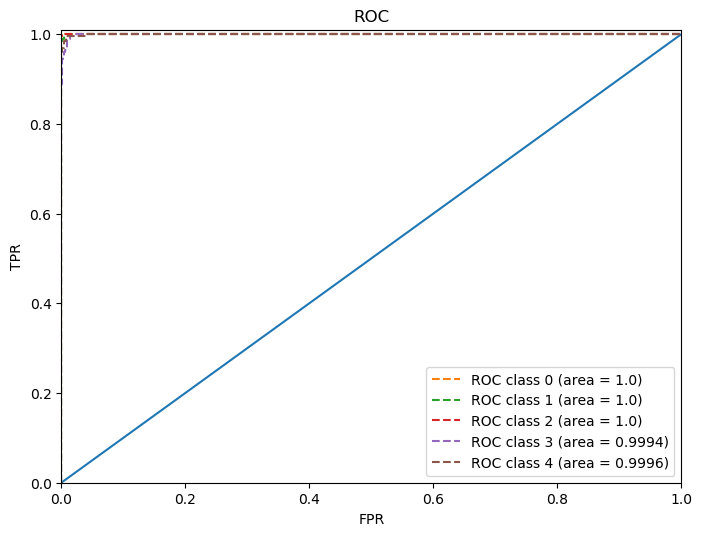

In [14]:
plt.figure(figsize=(8, 6), dpi=100)
plt.plot([0, 1])
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC class {} (area = {:.4})'.format(i, roc_auc[i]), linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc='best')
plt.show()